In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA, TruncatedSVD

In [3]:
df = pd.read_json('data/data.json')
# create binary labels for fraud and not fraud
fraud_idx = df[(df.acct_type=='fraudster_event')| (df.acct_type=='fraudster')|(df.acct_type=='fraudster_att')].index
# create label column
df['label'] = 0
df['label'].iloc[list(fraud_idx)]=1 # changes fraud labels to 1

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
df['soups'] = df.description.apply(lambda x: BeautifulSoup(x) )

def get_text(soup):
    return [p.text.replace('\xa0', '') for p in soup.find_all('p') if p.text.replace('\xa0', '') != '']

df.soups = df.soups.apply(lambda x: get_text(x))

In [5]:
all_descriptions = df.soups.apply(lambda x: ''.join(x))

In [8]:
fraud_post = df.label.value_counts()[1]/df.label.count()
print('Fraud Posterior Probability: {}'.format(fraud_post))

Fraud Posterior Probability: 0.09018623142916929


In [9]:
tfidf = TfidfVectorizer(stop_words='english')
vecs = tfidf.fit_transform(all_descriptions)

vec_arr = vecs.toarray()

In [10]:
vec_arr.shape

(14337, 132415)

In [11]:
X = vec_arr
y = df.label.values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

KeyboardInterrupt: 

In [16]:
grad_boost = GradientBoostingClassifier()
log_reg = LogisticRegression(solver='lbfgs')
rand_forest = RandomForestClassifier()
models = [grad_boost, log_reg, rand_forest]

In [12]:
cv_results = cross_validate(rand_forest, X_train, y_train, scoring='roc_auc', cv=3)

print("Cross Validated Roc Auc: {}".format(cv_results['test_score']))
print("Mean: {:0.3f}".format( cv_results['test_score'].mean()))

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Cross Validated Roc Auc: [0.79058117 0.8044297  0.7915932 ]
Mean: 0.796


In [13]:
decomp = TruncatedSVD(n_components=100)
lsaX = decomp.fit_transform(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(lsaX, y)

In [17]:
cv_results = cross_validate(grad_boost, X_train, y_train, scoring='roc_auc', cv=3)

print("Cross Validated Roc Auc: {}".format(cv_results['test_score']))
print("Mean: {:0.3f}".format( cv_results['test_score'].mean()))

Cross Validated Roc Auc: [0.82415951 0.80753689 0.80587472]
Mean: 0.813


In [18]:
grad_boost.fit(X_train, y_train)
grad_boost.score(X_test, y_test)

0.9118549511854951

In [21]:
y_pred = grad_boost.predict(X_test)

In [25]:
y_pred[y_pred == 1] = 0

(3585,)

In [19]:
from sklearn.metrics import auc, roc_curve

def roc_plot(y_test, y_scores, g_params="ROC"):    
    '''
    plots an roc curve
    Input:
        y_test:     labeled y_test values
        y_scores:   classifier.fit(X_train, y_train).decision_function(X_test)
        g_params:   str. describe model output
    '''
    
    n_classes = 1
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure() 
    lw = 2 
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title('ROC: Random Forest:  {} '.format(g_params)) 
    plt.legend(loc="lower right") 
    plt.show()

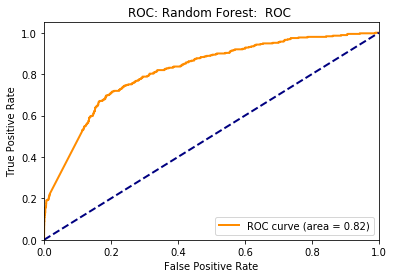

In [20]:
roc_plot(y_test, grad_boost.predict_proba(X_test)[:,1])

In [38]:
test

array([[ 0.1437455 , -0.13786345, -0.0109602 , ..., -0.01877804,
         0.0008359 , -0.02550502],
       [ 0.16101228, -0.04468005,  0.00675616, ...,  0.02078817,
        -0.01187245,  0.00992461],
       [ 0.19995811, -0.01385281, -0.00244623, ..., -0.02141503,
        -0.04645869,  0.01109585],
       ...,
       [ 0.08398828, -0.01205656,  0.00378501, ...,  0.02531257,
         0.03233859, -0.03322415],
       [ 0.09159476, -0.07474   , -0.00052061, ..., -0.0227194 ,
        -0.0040191 ,  0.01407754],
       [ 0.        ,  0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ]])

In [41]:
from model import get_features

In [42]:
X,y = get_features(df)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/clairemason/Galvanize/fraud_case_study/fraud_detection_clean/model.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['country_cat'][df.country.isin(fraud_prone_countries)] = 1


In [47]:
final = pd.concat((X, pd.DataFrame(test)), axis=1)

In [49]:
rand_forest.fit(final.values, y)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)